# 케글 1등 따라하기 
https://www.kaggle.com/code/startupsci/titanic-data-science-solutions

In [244]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

In [245]:
train_df = pd.read_csv("./train.csv")
test_df = pd.read_csv("./test.csv")

combine = [train_df, test_df]
# 전처리 시 train_df, test_df 둘 다 동시에 처리해주기 위해 하나의 변수에 담고
# for문을 이용해 같이 처리한다.

train_df.info()
print('-'*40)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Passenger

## Object형 처리하기

In [246]:
train_df.describe(include=['O']) # Object형만 describe

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


1. Name : 전부 유니크한 값이니 제거한다.
2. Ticket : 유니크 값이 681개나 되고 null값도 많으므로 제거한다.
3. Cabin : 대부분 유니크한 값이고 null값도 많으므로 제거한다.
4. 이 외에도 PassengerId는 Name과 같은 고유한 값이기 때문에 제거한다.

In [247]:
print("Before", train_df.shape, test_df.shape, combine[0].shape, combine[1].shape)

Before (891, 12) (418, 11) (891, 12) (418, 11)


In [248]:
# 우선 Ticket과 Cabin을 제거한다.
train_df = train_df.drop(['Ticket', 'Cabin'], axis=1)
test_df = test_df.drop(['Ticket', 'Cabin'], axis=1)
combine = [train_df, test_df]

---
### Name 전처리 & 피처 엔지니어링

In [249]:
# Name 컬럼을 그냥 지우기 보다는 이를 이용해 새로운 컬럼을 만들어보자.
# 일단 Name 의 . 앞에 있는 작위(?)들을 가져와 새로운 데이터셋에 담고 성별에 따라 분류해본다.

for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    
pd.crosstab(train_df['Title'], train_df['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


In [250]:
# 거의 유니크한 작위들은 'Rare'로 통일하고
# Mlle, Ms, Mme는 오타인 것 같아 수정한다.
for dataset in combine:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    
train_df[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.347826


In [251]:
# 5개의 작위들에 번호를 부여한다.
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
for dataset in combine:
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,3
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,3
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,1


In [252]:
# 이제 Name은 삭제하고, train_df의 PassengerId도 삭제한다.
train_df = train_df.drop(['Name', 'PassengerId'], axis=1)
test_df = test_df.drop(['Name', 'PassengerId'], axis=1)
combine = [train_df, test_df]
train_df.shape, test_df.shape

((891, 9), (418, 8))

---
### Sex 0과 1로 매핑

In [253]:
# 성별 매핑
for dataset in combine:
    dataset['Sex'] = dataset['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,22.0,1,0,7.2500,S,1
1,1,1,1,38.0,1,0,71.2833,C,3
2,1,3,1,26.0,0,0,7.9250,S,2
3,1,1,1,35.0,1,0,53.1000,S,3
4,0,3,0,35.0,0,0,8.0500,S,1


In [254]:
dataset

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,3,0,34.5,0,0,7.8292,Q,1
1,3,1,47.0,1,0,7.0000,S,3
2,2,0,62.0,0,0,9.6875,Q,1
3,3,0,27.0,0,0,8.6625,S,1
4,3,1,22.0,1,1,12.2875,S,3
...,...,...,...,...,...,...,...,...
413,3,0,NaN,0,0,8.0500,S,1
414,1,1,39.0,0,0,108.9000,C,5
415,3,0,38.5,0,0,7.2500,S,1
416,3,0,NaN,0,0,8.0500,S,1


---
### Age 전처리 & 피처 엔지니어링

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


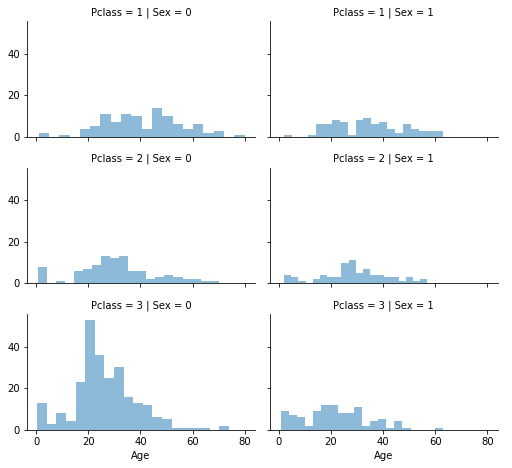

In [255]:
# 이제 Age의 null 값을 처리해야 한다.
# 방법 1 : 간단한 방법은 평균과 표준 편차 사이에 난수를 생성하는 것이다.
# 방법 2 : 보다 정확한 방법은 다른 상관된 형상을 사용하는 것이다. 우리의 경우 나이, 성별, 그리고 P클래스 사이의 상관관계를 주목할 필요가 있다.
# 방법 1,2를 결합해보자

# grid = sns.FacetGrid(train_df, col='Pclass', hue='Gender')
grid = sns.FacetGrid(train_df, row='Pclass', col='Sex', size=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend()

In [256]:
# 이제 Sex(0 또는 1)과 Pclass(1, 2, 3)를 조합해서 연령 추정치를 계산합니다.

# 먼저 빈 2,3 행렬을 만든다
guess_ages = np.zeros((2,3))
guess_ages

array([[0., 0., 0.],
       [0., 0., 0.]])

In [257]:
for dataset in combine:
    for i in range(0, 2):
        for j in range(0, 3):
            guess_df = dataset[(dataset['Sex'] == i) & \
                                  (dataset['Pclass'] == j+1)]['Age'].dropna()

            # age_mean = guess_df.mean()
            # age_std = guess_df.std()
            # age_guess = rnd.uniform(age_mean - age_std, age_mean + age_std)

            age_guess = guess_df.median()

            # Convert random age float to nearest .5 age # 이건 왜 하는건지 모르겠다.
            guess_ages[i,j] = int( age_guess/0.5 + 0.5 ) * 0.5 # 어짜피 결과는 age_guess랑 같아지는데..?
            
    for i in range(0, 2):
        for j in range(0, 3):
            dataset.loc[ (dataset.Age.isnull()) & (dataset.Sex == i) & (dataset.Pclass == j+1),\
                    'Age'] = guess_ages[i,j]

    dataset['Age'] = dataset['Age'].astype(int)

train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,22,1,0,7.2500,S,1
1,1,1,1,38,1,0,71.2833,C,3
2,1,3,1,26,0,0,7.9250,S,2
3,1,1,1,35,1,0,53.1000,S,3
4,0,3,0,35,0,0,8.0500,S,1


In [258]:
guess_ages

array([[42., 28., 24.],
       [41., 24., 22.]])

In [259]:
# Age는 범주형인듯 연속형인 듯 애매하다.
# 따라서 10대, 20대와 같이 묶어서 완전히 범주형으로 만들자

train_df['AgeBand'] = pd.cut(train_df['Age'], 8)
train_df[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False).mean().sort_values(by='AgeBand', ascending=True)

,AgeBand,Survived
0,"(-0.08, 10.0]",0.593750
1,"(10.0, 20.0]",0.379310
2,"(20.0, 30.0]",0.322751
3,"(30.0, 40.0]",0.448649
4,"(40.0, 50.0]",0.392857
5,"(50.0, 60.0]",0.404762
6,"(60.0, 70.0]",0.222222
7,"(70.0, 80.0]",0.250000


In [260]:
for dataset in combine:    
    dataset.loc[ dataset['Age'] <= 10, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 10) & (dataset['Age'] <= 20), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 20) & (dataset['Age'] <= 30), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 30) & (dataset['Age'] <= 40), 'Age'] = 3
    dataset.loc[(dataset['Age'] > 40) & (dataset['Age'] <= 50), 'Age'] = 4
    dataset.loc[(dataset['Age'] > 50) & (dataset['Age'] <= 60), 'Age'] = 5
    dataset.loc[(dataset['Age'] > 60) & (dataset['Age'] <= 70), 'Age'] = 6
    dataset.loc[ dataset['Age'] > 70, 'Age'] = 7

train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,AgeBand
0,0,3,0,2,1,0,7.2500,S,1,"(20.0, 30.0]"
1,1,1,1,3,1,0,71.2833,C,3,"(30.0, 40.0]"
2,1,3,1,2,0,0,7.9250,S,2,"(20.0, 30.0]"
3,1,1,1,3,1,0,53.1000,S,3,"(30.0, 40.0]"
4,0,3,0,3,0,0,8.0500,S,1,"(30.0, 40.0]"


In [261]:
# 임시로 만든 AgeBand는 제거한다.
train_df = train_df.drop(['AgeBand'], axis=1)
combine = [train_df, test_df]
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,2,1,0,7.2500,S,1
1,1,1,1,3,1,0,71.2833,C,3
2,1,3,1,2,0,0,7.9250,S,2
3,1,1,1,3,1,0,53.1000,S,3
4,0,3,0,3,0,0,8.0500,S,1


In [262]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Sex       418 non-null    int32  
 2   Age       418 non-null    int32  
 3   SibSp     418 non-null    int64  
 4   Parch     418 non-null    int64  
 5   Fare      417 non-null    float64
 6   Embarked  418 non-null    object 
 7   Title     418 non-null    int64  
dtypes: float64(1), int32(2), int64(4), object(1)
memory usage: 23.0+ KB


---
### SibSp, Parch 전처리 & 피처 엔지니어링

In [263]:
# 이제 SibSp와 Parch를 이용해 FamilySize 컬럼을 만들어보자!
# 두 컬럼은 서로 성격이 비슷해서 합쳐도 될 것 같다.

# SibSp : 배에 탄 형제/배우자 수
# Parch배에 탄 부모/자녀의 수

In [264]:

train_df[["SibSp", "Survived"]].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [265]:
train_df[["Parch", "Survived"]].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


In [266]:
train_df[["SibSp", "Survived"]].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [267]:
for dataset in combine:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1 # 1은 자기자신
    
train_df[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(by='Survived', ascending=False) 

,FamilySize,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.136364
7,8,0.000000
8,11,0.000000


In [268]:
# FamilySize를 이용해 혼자 탄 사람인지 아닌지 분류해서 IsAlone 컬럼으로 만들어보자
for dataset in combine:
    dataset['IsAlone'] = 0 # 기본적으로 0을 다 부여하고
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1 # 1이면 혼자인걸로

train_df[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean()

,IsAlone,Survived
0,0,0.505650
1,1,0.303538


In [269]:
# 사용한 데이터는 지운다
train_df = train_df.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
test_df = test_df.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
combine = [train_df, test_df]

train_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone
0,0,3,0,2,7.2500,S,1,0
1,1,1,1,3,71.2833,C,3,0
2,1,3,1,2,7.9250,S,2,1
3,1,1,1,3,53.1000,S,3,0
4,0,3,0,3,8.0500,S,1,1


---
### Embarked 전처리 & 피처 엔지니어링

In [270]:
# Embarked에 2개의 결측값이 있다.
# 이건 그냥 최빈값으로 채우도록 하자.
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    int32  
 3   Age       891 non-null    int32  
 4   Fare      891 non-null    float64
 5   Embarked  889 non-null    object 
 6   Title     891 non-null    int64  
 7   IsAlone   891 non-null    int64  
dtypes: float64(1), int32(2), int64(4), object(1)
memory usage: 48.9+ KB


In [271]:
# Embarked에서 결측값을 제외한 최빈값을 찾는다.
train_df.Embarked.dropna().mode()

0    S
dtype: object

In [272]:
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
    
train_df[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.339009


In [273]:
dataset

,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone
0,3,0,3,7.8292,Q,1,1
1,3,1,4,7.0000,S,3,0
2,2,0,6,9.6875,Q,1,1
3,3,0,2,8.6625,S,1,1
4,3,1,2,12.2875,S,3,0
...,...,...,...,...,...,...,...
413,3,0,2,8.0500,S,1,1
414,1,1,3,108.9000,C,5,1
415,3,0,3,7.2500,S,1,1
416,3,0,2,8.0500,S,1,1


In [274]:
# 문자형인 Embarked를 숫자형으로 바꾼다.
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

train_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone
0,0,3,0,2,7.2500,0,1,0
1,1,1,1,3,71.2833,1,3,0
2,1,3,1,2,7.9250,0,2,1
3,1,1,1,3,53.1000,0,3,0
4,0,3,0,3,8.0500,0,1,1


---
### Fare 전처리 & 피처 엔지니어링

In [275]:
train_df.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
Fare        0
Embarked    0
Title       0
IsAlone     0
dtype: int64

In [276]:
test_df['Fare'].fillna(test_df['Fare'].dropna().median(), inplace=True)

In [277]:
train_df['FareBand'] = pd.qcut(train_df['Fare'], 4)
train_df[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by='FareBand', ascending=True)

,FareBand,Survived
0,"(-0.001, 7.91]",0.197309
1,"(7.91, 14.454]",0.303571
2,"(14.454, 31.0]",0.454955
3,"(31.0, 512.329]",0.581081


In [278]:
for dataset in combine:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

train_df = train_df.drop(['FareBand'], axis=1)
combine = [train_df, test_df]
    
train_df.head(10)

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone
0,0,3,0,2,0,0,1,0
1,1,1,1,3,3,1,3,0
2,1,3,1,2,1,0,2,1
3,1,1,1,3,3,0,3,0
4,0,3,0,3,1,0,1,1
5,0,3,0,2,1,2,1,1
6,0,1,0,5,3,0,1,1
7,0,3,0,0,2,0,4,0
8,1,3,1,2,1,0,3,0
9,1,2,1,1,2,1,3,0


---
## Model, predict and solve

### LogisticRegression (케글 1등 방법)

In [315]:
X_train = train_df.drop("Survived", axis=1)
Y_train = train_df["Survived"]
X_test  = test_df.copy()
X_train.shape, Y_train.shape, X_test.shape

((891, 7), (891,), (418, 7))

In [316]:
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)
acc_log = logreg.score(X_train, Y_train)
acc_log

0.8125701459034792

In [317]:
coeff_df = pd.DataFrame(train_df.columns.delete(0))
coeff_df.columns = ['Feature']
coeff_df["Correlation"] = pd.Series(logreg.coef_[0])

coeff_df.sort_values(by='Correlation', ascending=False)

,Feature,Correlation
1,Sex,2.196195
5,Title,0.402060
4,Embarked,0.293566
6,IsAlone,0.202706
3,Fare,-0.044321
2,Age,-0.312809
0,Pclass,-1.197936


### LogisticRegression (예시 방법)

In [324]:
x = train_df.drop(['Survived'], axis=1)
y = train_df.Survived.copy()

In [325]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=123)

In [326]:
logreg = LogisticRegression()
logreg.fit(x_train, y_train)
y_pred = logreg.predict(x_test)

In [339]:
print("Accuracy:", metrics.accuracy_score(y_test, y_pred)) 
# 정확도 : 전체 중에서 맞춘 것의 비율
print("Precision:", metrics.precision_score(y_test, y_pred)) 
# 정밀도 : 내가 참이라고 분류한 것 중에서 실제 참인 것의 비율 = 예측값이 얼마나 정확한가
print("Recall:", metrics.recall_score(y_test, y_pred))
# 재현율(검출율, = 민감도) : 실제 참인 것들 중에서 내가 참이라고 분류한 것의 비율 = 실제 정답을 얼마나 맞췄는가
print("F1_score:", metrics.f1_score(y_test, y_pred))
# F1_score : precision 과 recall의 조화평균 = 2 * ((precision * recall) / (precision + recall))

Accuracy: 0.8071748878923767
Precision: 0.7469879518072289
Recall: 0.7380952380952381
F1_score: 0.7425149700598803


### LogisticRegression (예시 방법) + K-fold Cross Validation

In [354]:
# from sklearn.model_selection import cross_val_score
# 딕셔너리를 이용한 scoring 방법은 version 0.19 부터 cross_val_score 가 아닌 cross_validate 에서 사용 가능하다
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score), 
           'f1_score' : make_scorer(f1_score)}

scores = cross_validate(logreg, x, y, cv=30, scoring=scoring)

#print('교차 검증별 정확도:',np.round(scores, 4))
#print('평균 검증 정확도:', np.round(np.mean(scores), 4))
print("Accuracy:", np.mean(scores['test_accuracy']))
print("Precision:", np.mean(scores['test_precision']))
print("Recall:", np.mean(scores['test_recall']))
print("F1_score:", np.mean(scores['test_f1_score']))

Accuracy: 0.8091954022988506
Precision: 0.7746141821141822
Recall: 0.7280303030303031
F1_score: 0.7446105897661962


**KFold 상세 조정**

위 cross_val_score 함수에서는, cv로 폴드의 수를 조정할 수 있었다.

만약 검증함수의 매개변수를 디테일하게 제어하고 싶다면 따로 검증함수 객체를 만들고 매개변수를 조정한 다음,
해당 객체를 cross_val_score의 cv 매개변수에 넣을 수도 있다.

이를 '교차 검증 분할기' 라고도 한다.

In [363]:
from sklearn.model_selection import KFold

# n_split : 몇개로 분할할지
# shuffle : Fold를 나누기 전에 무작위로 섞을지
# random_state : 나눈 Fold를 그대로 사용할지
kfold = KFold(n_splits=30, shuffle = True, random_state=2022)

scores = cross_validate(logreg , x , y ,cv=kfold, scoring=scoring)

#print('교차 검증별 정확도:',np.round(scores, 4))
#print('평균 검증 정확도:', np.round(np.mean(scores), 4))
print("Accuracy:", np.mean(scores['test_accuracy']))
print("Precision:", np.mean(scores['test_precision']))
print("Recall:", np.mean(scores['test_recall']))
print("F1_score:", np.mean(scores['test_f1_score']))

Accuracy: 0.8034099616858239
Precision: 0.7760929783723901
Recall: 0.7270590983090983
F1_score: 0.741138119124241


**계층별(층화, stratified) K-fold Cross Validation**

데이터가 편항되어 있을 경우(몰려있 경우) 단순 k-겹 교차검증을 사용하면 성능 평가가 잘 되지 않을 수 있다.<br>
따라서 이럴 때는 stratified k-fold cross-validation을 사용한다.

일반적으로 회귀에는 기본 k-겹 교차검증을 사용하고,<br>
분류에는 StratifiedKFold를 사용한다.

In [361]:
from sklearn.model_selection import StratifiedKFold

skfold = StratifiedKFold(n_splits=30, shuffle=True, random_state=2022)
scores = cross_validate(logreg , x , y ,cv=skfold, scoring=scoring)

#print('교차 검증별 정확도:',np.round(scores, 4))
#print('평균 검증 정확도:', np.round(np.mean(scores), 4))
print("Accuracy:", np.mean(scores['test_accuracy']))
print("Precision:", np.mean(scores['test_precision']))
print("Recall:", np.mean(scores['test_recall']))
print("F1_score:", np.mean(scores['test_f1_score']))

Accuracy: 0.8061302681992337
Precision: 0.7721450771450769
Recall: 0.723989898989899
F1_score: 0.741963128658781


### Support Vector Machines
- https://blog.naver.com/jgyy4775/222637846475
- 기준선인 결정경계를 통해 데이터를 분류
- 결정경계를 기준으로 데이터 군집과 떨어진 거리를 마진(margin)이라고 하며 SVM은 이 마진을 최대화하는 결정경계를 찾는 것이다.
- 장점 : 오류 데이터의 영향이 적고 과적합이 잘 일어나지 않는다. 회귀분석에도 사용가능하다.
- 단점 : 데이터가 많아지면 학습 속도가 느리고 메모리를 많이 사용한다. 오버/언더피팅을 피하기 위해 매개변수를 잘 설정해주어야 한다.

In [161]:
svc = SVC() # 함수명은 SVM이 아닌 SVC이다. 아마 Support Vector machines Classification ?
svc.fit(X_train, Y_train)
Y_pred = svc.predict(X_test)
acc_svc = round(svc.score(X_train, Y_train) * 100, 2)
acc_svc

82.72

### KNeighborsClassifier

In [162]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)
acc_knn = round(knn.score(X_train, Y_train) * 100, 2)
acc_knn

85.75